## Integration of PCA and K-Means to Cluster Soccer Players into Similar Groups 

This project uses an open dataset from the popular site Kaggle (https://www.kaggle.com/hugomathien/soccer). 
The dataset is a European Soccer Database and has more than 25,000 matches and more than 10,000 players for European 
professional soccer seasons from 2008 to 2016.

The dataset contains other details like match result details and countries.

The exploratory data analysis include some steps for exploring and cleaning our dataset, 
some steps for predicting player performance using correlation and domain knowledge, 
and some steps for grouping similar clusters using machine learning.

In [1]:
#libraries

import os #interface with operating system
import sqlite3 as sql #connection to the SQL database
import pandas as pd #dataframe constructor
import numpy as np #data manipulation
import matplotlib.pyplot as plt #plotting and visualization library
from sklearn.decomposition import PCA #principal components analysis library
from sklearn.preprocessing import scale #scaling library
from sklearn.cluster import KMeans #clustering model

In [2]:
#importing sql data into python

conn = sql.connect('European Soccer Data\\database.sqlite')
players_data = pd.read_sql('select * from Player_Attributes',conn)

In [3]:
#view of the top five records

players_data.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [4]:
#probe into the shape of data

players_data.shape

(183978, 42)

In [5]:
#check and drop of duplicate records in the data

players_data.dropna(inplace = True)
players_data = players_data.drop_duplicates(subset = 'player_api_id')
players_data.shape

(10410, 42)

In [6]:
#check for null values

players_data.isnull().any().any()

False

In [7]:
#view of the top five records after removing duplicates

players_data.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
5,6,189615,155782,2016-04-21 00:00:00,74.0,76.0,left,high,medium,80.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
38,39,186170,162549,2016-01-07 00:00:00,65.0,67.0,right,medium,medium,64.0,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
64,65,140161,30572,2016-04-21 00:00:00,69.0,69.0,right,medium,medium,57.0,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
87,88,17725,23780,2015-12-24 00:00:00,70.0,70.0,right,medium,medium,46.0,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0


In [8]:
players_data.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [9]:
#check of correlation of other attributes with overall_rating values

players_attributes = players_data[['overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy', 
                                   'short_passing', 'volleys', 'dribbling', 'curve', 'long_passing', 'ball_control', 
                                   'acceleration', 'sprint_speed', 'reactions', 'shot_power','long_shots', 'aggression',
                                   'interceptions', 'positioning', 'vision', 'marking','standing_tackle','sliding_tackle']]

#Pearson's correlation coeeficients
for attribute in players_attributes:
    related = players_data['overall_rating'].corr(players_data[attribute])
    print("%s: %f" % (attribute, related))

overall_rating: 1.000000
potential: 0.817766
crossing: 0.292637
finishing: 0.266259
heading_accuracy: 0.236227
short_passing: 0.411985
volleys: 0.303953
dribbling: 0.295225
curve: 0.325220
long_passing: 0.391255
ball_control: 0.379493
acceleration: 0.175934
sprint_speed: 0.189308
reactions: 0.790788
shot_power: 0.348248
long_shots: 0.325896
aggression: 0.267939
interceptions: 0.201302
positioning: 0.284508
vision: 0.410448
marking: 0.119554
standing_tackle: 0.149165
sliding_tackle: 0.131721


In [10]:
#selection of players competent to a certain degree in their position of play using overall_rating and potential

players_data = players_data[players_data['overall_rating'] >= 77]
players_data = players_data[players_data['potential'] >= 70]

In [11]:
#check for the shape of new data

players_data.shape

(974, 42)

In [12]:
#in my opinion, the following attributes distinguish players from each other considering the position played on the field 

selected_attributes = ['finishing', 'volleys', 'shot_power', 'short_passing', 'vision', 'long_passing', 'marking',
                       'standing_tackle', 'sliding_tackle']

players_data = players_data[selected_attributes].copy(deep = True)

In [13]:
#view of top five records of new data

players_data.head()

,finishing,volleys,shot_power,short_passing,vision,long_passing,marking,standing_tackle,sliding_tackle
112,72.0,77.0,76.0,79.0,76.0,70.0,28.0,34.0,35.0
146,66.0,68.0,62.0,76.0,73.0,54.0,30.0,34.0,35.0
269,75.0,79.0,81.0,83.0,81.0,80.0,62.0,74.0,68.0
857,48.0,41.0,59.0,73.0,55.0,67.0,73.0,79.0,78.0
899,72.0,69.0,88.0,73.0,70.0,76.0,13.0,28.0,23.0


In [14]:
#scaling of data for analysis

x = players_data.values #converts the data into a numpy array
x = scale(x); x

array([[ 0.64556009,  0.90053914,  0.36315931, ..., -0.8308694 ,
        -0.82391298, -0.6588441 ],
       [ 0.37600785,  0.48063882, -0.42967456, ..., -0.75590606,
        -0.82391298, -0.6588441 ],
       [ 0.78033621,  0.99385032,  0.64631427, ...,  0.44350747,
         0.70719361,  0.58500712],
       ...,
       [ 0.37600785,  0.76057236,  0.4764213 , ...,  0.70587918,
         0.55408295,  0.47192974],
       [ 0.87018696,  0.52729441,  0.30652832, ..., -0.64346104,
        -0.40285867, -0.62115164],
       [ 0.55570934,  0.90053914,  0.36315931, ..., -1.05575944,
        -0.93874598, -0.84730641]])

In [15]:
#cumulative sum of variance explained with 9 features

covar_matrix = PCA(n_components = 9)
covar_matrix.fit(players_data)
variance = covar_matrix.explained_variance_ratio_ 
var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals = 3) * 100)
var

array([ 54.5,  92.3,  95.6,  96.9,  97.9,  98.7,  99.2,  99.6, 100. ])

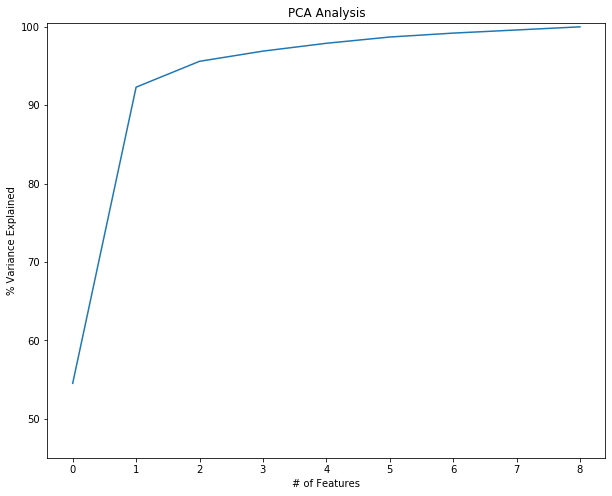

In [16]:
#visualization of cumulative sum of variance explained with 9 features

plt.figure(1, figsize = (10, 8))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(45, 100.5)
plt.style.context('seaborn-whitegrid')

plt.plot(var)

In [17]:
#compute cluster centers and predict cluster indices

model = KMeans(n_clusters = 4)
X_clustered = model.fit_predict(x)
players_cluster = pd.DataFrame(x)
players_cluster = players_cluster[[0, 1, 2, 3, 4, 5, 6, 7, 8]]
players_cluster['X_cluster'] = X_clustered

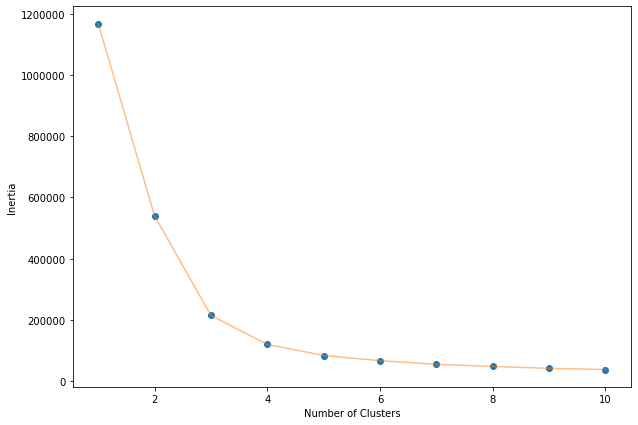

In [19]:
#check for suitable number of clusters using finishing and sliding_tackle

X1 = players_data[['finishing', 'sliding_tackle']].iloc[:, :].values
inertia = []
for n in range(1, 11):
    algorithm = (KMeans(n_clusters = n, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001,  random_state = 111,
                        algorithm = 'elkan'))
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)
    
plt.figure(1, figsize = (10, 7))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters'), plt.ylabel('Inertia')
plt.show()

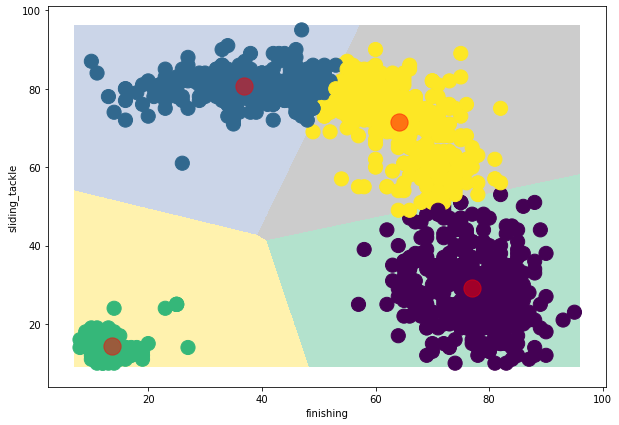

In [20]:
#clusters using finishing and sliding tackle

algorithm = (KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001,random_state = 111,
                    algorithm = 'elkan'))
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (10, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation = 'nearest', extent = (xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, 
           aspect = 'auto', origin = 'lower')

plt.scatter(x = 'finishing', y = 'sliding_tackle', data = players_data, c = labels1, s = 200)
plt.scatter(x = centroids1[:, 0], y = centroids1[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.ylabel('sliding_tackle'), plt.xlabel('finishing')
plt.show()

In [21]:
#count of players in each cluster

print("Count of players in each cluster")
print(40*'_')

pd.value_counts(algorithm.labels_, sort = False)

Count of players in each cluster
________________________________________


0    358
1    226
2     95
3    295
dtype: int64

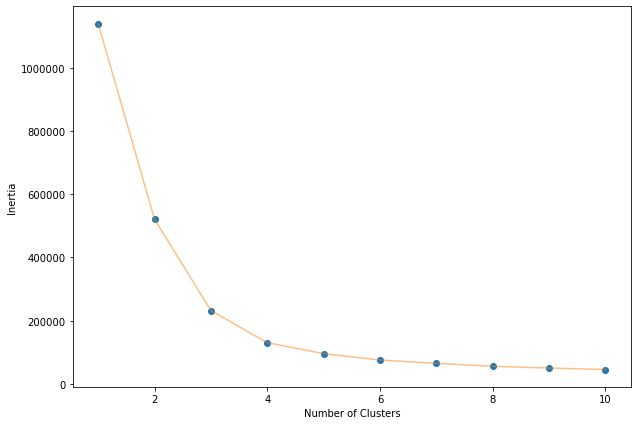

In [22]:
#check for suitable number of clusters using volleys and marking

X2 = players_data[['volleys', 'marking']].iloc[:, :].values
inertia = []
for n in range(1, 11):
    algorithm = (KMeans(n_clusters = n, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, random_state = 111,
                        algorithm = 'elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)
    
plt.figure(1, figsize = (10, 7))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters'), plt.ylabel('Inertia')
plt.show()

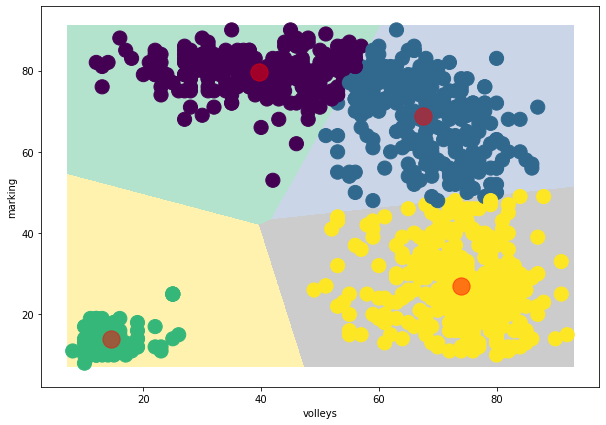

In [23]:
algorithm = (KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, random_state = 111,
                    algorithm = 'elkan'))
algorithm.fit(X2)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (10, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation = 'nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, 
           aspect = 'auto', origin = 'lower')

plt.scatter(x = 'volleys', y = 'marking', data = players_data, c = labels1, s = 200)
plt.scatter(x = centroids1[:, 0] , y = centroids1[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.ylabel('marking'), plt.xlabel('volleys')
plt.show()

In [24]:
#count of players in each cluster

print("Count of players in each cluster")
print(40*'_')

pd.value_counts(algorithm.labels_, sort = False)

Count of players in each cluster
________________________________________


0    249
1    258
2     95
3    372
dtype: int64

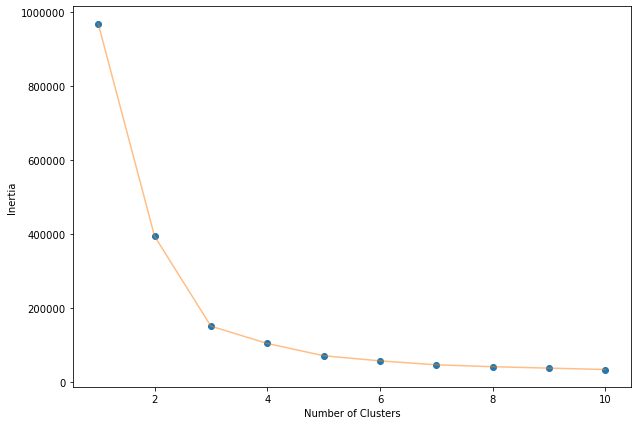

In [25]:
#check for suitable number of clusters using shot_power and standing_tackle

X3 = players_data[['shot_power', 'standing_tackle']].iloc[:, :].values
inertia = []
for n in range(1, 11):
    algorithm = (KMeans(n_clusters = n, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, random_state = 111,
                        algorithm = 'elkan'))
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)
    
plt.figure(1, figsize = (10, 7))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters'), plt.ylabel('Inertia')
plt.show()

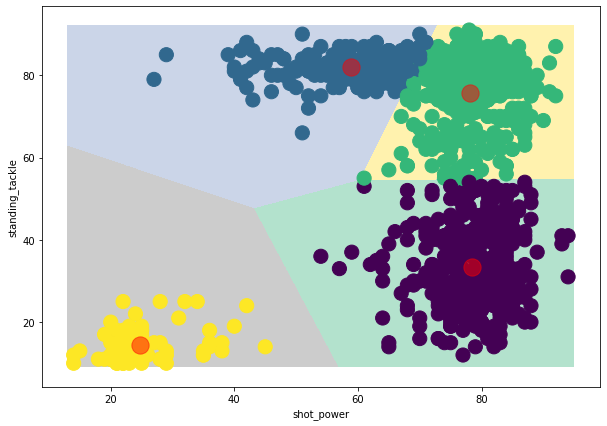

In [26]:
algorithm = (KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, random_state = 111,
                    algorithm = 'elkan'))
algorithm.fit(X3)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X3[:, 0].min() - 1, X3[:, 0].max() + 1
y_min, y_max = X3[:, 1].min() - 1, X3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (10, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation = 'nearest', extent = (xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, 
           aspect = 'auto', origin = 'lower')

plt.scatter(x = 'shot_power', y = 'standing_tackle', data = players_data, c = labels1, s = 200)
plt.scatter(x = centroids1[:, 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.ylabel('standing_tackle'), plt.xlabel('shot_power')
plt.show()

In [27]:
#count of players in each cluster

print("Count of players in each cluster")
print(40*'_')

pd.value_counts(algorithm.labels_, sort = False)

Count of players in each cluster
________________________________________


0    353
1    174
2    352
3     95
dtype: int64

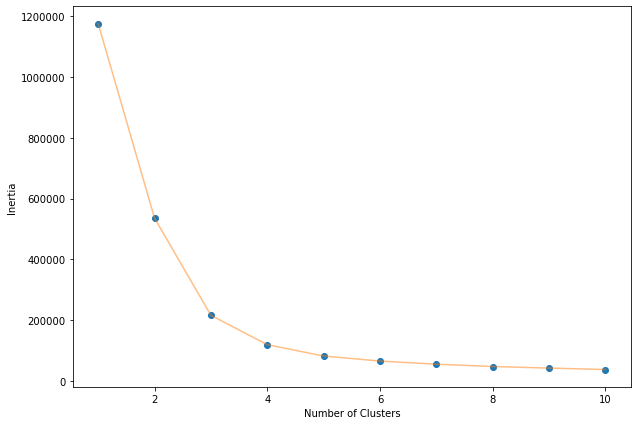

In [28]:
#check for suitable number of clusters using finishing and marking

X4 = players_data[['finishing', 'marking']].iloc[:,:].values
inertia = []
for n in range(1, 11):
    algorithm = (KMeans(n_clusters = n, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, random_state = 111,
                        algorithm = 'elkan') )
    algorithm.fit(X4)
    inertia.append(algorithm.inertia_)
    
plt.figure(1, figsize = (10, 7))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters'), plt.ylabel('Inertia')
plt.show()

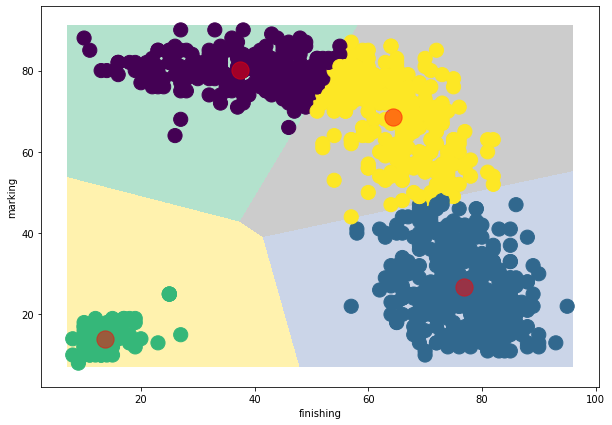

In [29]:
algorithm = (KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001,  random_state = 111,
                    algorithm = 'elkan') )
algorithm.fit(X4)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X4[:, 0].min() - 1, X4[:, 0].max() + 1
y_min, y_max = X4[:, 1].min() - 1, X4[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (10, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation = 'nearest', extent = (xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, 
           aspect = 'auto', origin = 'lower')

plt.scatter(x = 'finishing', y = 'marking', data = players_data, c = labels1, s = 200)
plt.scatter(x = centroids1[:, 0], y = centroids1[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.ylabel('marking'), plt.xlabel('finishing')
plt.show()

In [30]:
#count of players in each cluster

print("Count of players in each cluster")
print(40*'_')

pd.value_counts(algorithm.labels_, sort = False)

Count of players in each cluster
________________________________________


0    234
1    367
2     95
3    278
dtype: int64

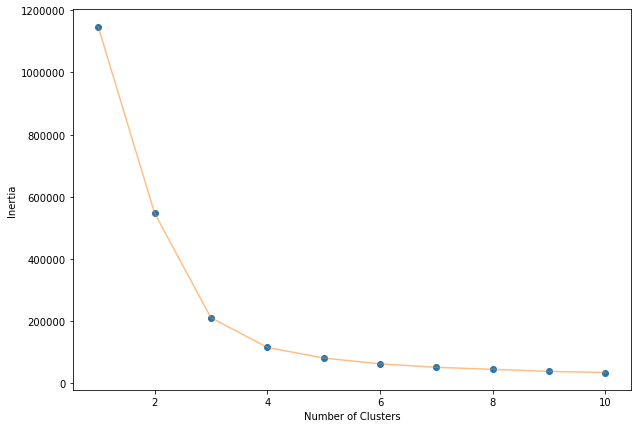

In [31]:
#check for suitable number of clusters using finishing and standing_tackle

X5 = players_data[['finishing', 'standing_tackle']].iloc[:,:].values
inertia = []
for n in range(1, 11):
    algorithm = (KMeans(n_clusters = n, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001,  random_state = 111,
                        algorithm = 'elkan') )
    algorithm.fit(X5)
    inertia.append(algorithm.inertia_)
    
plt.figure(1, figsize = (10, 7))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters'), plt.ylabel('Inertia')
plt.show()

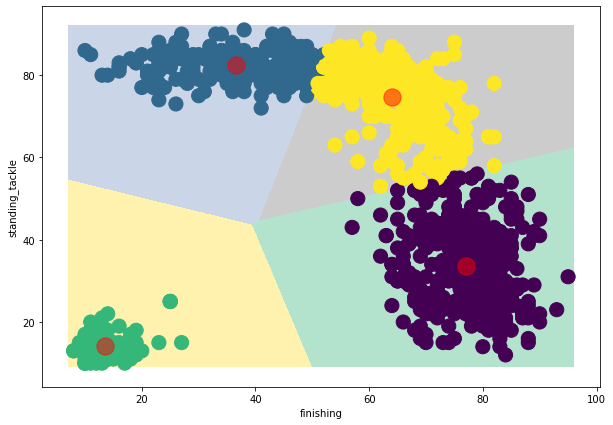

In [32]:
algorithm = (KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001,  random_state = 111,
                    algorithm = 'elkan') )
algorithm.fit(X5)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

h = 0.02
x_min, x_max = X5[:, 0].min() - 1, X5[:, 0].max() + 1
y_min, y_max = X5[:, 1].min() - 1, X5[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (10, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation = 'nearest', extent = (xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, 
           aspect = 'auto', origin = 'lower')

plt.scatter(x = 'finishing', y = 'standing_tackle', data = players_data, c = labels1, s = 200)
plt.scatter(x = centroids1[:, 0], y = centroids1[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.ylabel('standing_tackle'), plt.xlabel('finishing')
plt.show()

In [33]:
#count of players in each cluster

print("Count of players in each cluster")
print(40*'_')

pd.value_counts(algorithm.labels_, sort = False)

Count of players in each cluster
________________________________________


0    356
1    222
2     95
3    301
dtype: int64